# Hopfield Network
A Hopfield network has one layer of $N$ neurons and is a fully interconnected recurrent neural network: each neuron is connected to every other neuron. After initialization of all neurons (the initial input), the network is let to evolve: an output at time $t$ becomes an input at time $t+1$. Thus to generate a series of outputs, we have to provide only one initial input. In the course of this dynamical evolution the network should reach a stable state (an attractor), which is a configuration of neuron values that is not changed by subsequent updates of the network. Networks of this kind are used as models of associative memory. After initialization the network should evolve to the closest attractor.

## Colab Setup
This part is only required when running this notebook "in the cloud" on [Google Colab](https://colab.research.google.com). When running it locally, skip this part and go to the next section.

### [OPTIONAL] Interactive Plots
Run the below cell if you want to enable interactive plots in Google Colab. For most exercises this is not required and it can be quite slow.

In [1]:
!pip install ipympl
%matplotlib inline
from google.colab import output
output.enable_custom_widget_manager()

### [REQUIRED] Auxiliary Files

In [2]:
# Retrieve some auxiliary files from github
!wget https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/hopfield.py

--2025-07-30 13:18:14--  https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/hopfield.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8266 (8.1K) [text/plain]
Saving to: ‘hopfield.py.1’

hopfield.py.1       100%[===================>]   8.07K  --.-KB/s    in 0.001s  

2025-07-30 13:18:14 (13.6 MB/s) - ‘hopfield.py.1’ saved [8266/8266]



## Setup
Import all the necessary modules used throughout this notebook and define some methods to visualize the state space of 2D and 3D Hopfield networks, the energy evolution and the handwritten digits.

In [3]:
# Import the required modules for this notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from keras.datasets import mnist
from hopfield import HopfieldNetwork

rng = np.random.default_rng()

In [4]:
# 2D and 3D Hopfield networks:
def plot_targets(targets):
  N = targets.shape[1]
  fig, ax = plt.subplots(subplot_kw={'projection': '3d' if N == 3 else None})
  ax.scatter(*np.swapaxes(targets, 0, 1), color='y', marker='D', label='Targets')
  ax.set_xlim([-1.05, 1.05])
  ax.set_ylim([-1.05, 1.05])
  ax.set_zlim([-1.05, 1.05]) if N == 3 else None
  ax.set_title(f'Targets of a {N}D Hopfield network')
  plt.tight_layout()
  plt.show()

def plot_states(states, filename=None):
  if states.ndim == 2:
    states = np.expand_dims(states, 0)
  N = states.shape[1]
  fig, ax = plt.subplots(subplot_kw={'projection': '3d' if N == 3 else None})
  createLineCollection = Line3DCollection if N == 3 else LineCollection
  evolution = createLineCollection(np.swapaxes(states, 1, 2), color='b', zorder=0, label='State Evolution')
  ax.add_collection(evolution)
  s_init = states[:, :, 0]
  s_final = states[:, :, -1]
  ax.scatter(*np.swapaxes(s_init, 0, 1), color='g', marker='*', label='Initial State')
  ax.scatter(*np.swapaxes(s_final, 0, 1), color='r', marker='x', label='Final State')

  ax.set_xlim([-1.05, 1.05])
  ax.set_ylim([-1.05, 1.05])
  ax.set_zlim([-1.05, 1.05]) if N == 3 else None
  ax.set_title(f'Time evolution in the state space of a {N}D Hopfield network')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncols=4)

  plt.tight_layout()
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

def plot_energies(energies, filename=None):
  if energies.ndim == 1:
    energies = np.expand_dims(energies, 0)
  fig, ax = plt.subplots()
  ax.plot(energies.T)

  ax.set_title('Energy evolution of the states')

  plt.tight_layout()
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

# Digit reconstruction:
def plot_digits(digits, titles=None, filename=None):
  digits = np.asarray(digits)
  C, R = [1, 1, *digits.shape[:-1]][-2:]
  if titles is None:
    titles = [None]*C
  digits = digits.reshape((C, R, 28, 28))
  fig, axes = plt.subplots(R, C, squeeze=False, gridspec_kw={'wspace':1, 'hspace':0.05})
  for c, title in enumerate(titles):
    if title is not None:
      axes[0, c].set_title(title)
    for r in range(R):
      axes[r, c].imshow(digits[c, r], cmap='binary', vmin=-1, vmax=1)
      axes[r, c].axis('off')
  if filename is not None:
    plt.savefig(f'{filename}.svg')
  plt.show()

In [ ]:
def plot_energy_surface(net, states=None, *, filename=None):
    """Plot the energy surface of 2D Hopfield network."""
    if net.D != 2:
        print("This function only works for 2D Hopfield networks")
        return

    # Create a grid of states
    resolution = 100
    s1 = np.linspace(-1, 1, resolution)
    s2 = np.linspace(-1, 1, resolution)
    S1, S2 = np.meshgrid(s1, s2)

    # Calculate energy for each point in the grid
    grid_states = np.vstack([S1.flatten(), S2.flatten()]).T
    energy_values = net.energy(grid_states).reshape(S1.shape)

    # Create the plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the energy surface
    surf = ax.plot_surface(S1, S2, energy_values, cmap='viridis', alpha=0.8,
                          linewidth=0, antialiased=True)

    # If states are provided, plot the evolution path
    if states is not None:
        if states.ndim == 3:  # Multiple trajectories
            for traj in states:
                ax.plot(traj[0, :], traj[1, :],
                        net.energy(traj.T), 'r-o', linewidth=2, markersize=4)
        else:  # Single trajectory
            ax.plot(states[0, :], states[1, :],
                    net.energy(states.T), 'r-o', linewidth=2, markersize=4)

    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Set labels and title
    ax.set_xlabel('Neuron 1 state')
    ax.set_ylabel('Neuron 2 state')
    ax.set_zlabel('Energy')
    ax.set_title('Energy Surface of 2D Hopfield Network')

    if filename is not None:
        plt.savefig(f"../models/hopfield/{filename}.svg")
    plt.show()

def plot_states_energy_surface(net, states, energies, *, targets=None, filename=None):
    from matplotlib.gridspec import GridSpec

    if net.D == 2:
        fig = plt.figure(figsize=(22, 6))
        gs = GridSpec(1, 3, width_ratios=[7, 7, 8], figure=fig)
    else:
        fig = plt.figure(figsize=(14, 6))
        gs = GridSpec(1, 2, width_ratios=[7, 7], figure=fig)

    if states.ndim == 2:
        states = np.expand_dims(states, 0)
    N = states.shape[1]
    ax1 = fig.add_subplot(gs[0, 0], projection="3d" if N == 3 else None)
    createLineCollection = Line3DCollection if N == 3 else LineCollection
    evolution = createLineCollection(
        np.swapaxes(states, 1, 2), color="b", zorder=0, label="State Evolution" if targets is
        None else None
    )
    ax1.add_collection(evolution)
    s_init = states[:, :, 0]
    s_final = states[:, :, -1]
    ax1.scatter(*np.swapaxes(s_init, 0, 1), color="g", marker="*", label="Initial State")
    ax1.scatter(*np.swapaxes(s_final, 0, 1), color="r", marker="x", label="Final State")
    if targets is not None:
        ax1.scatter(*np.swapaxes(targets, 0, 1), color="y", marker="D", label="Targets")

    ax1.set_xlim([-1.05, 1.05])
    ax1.set_ylim([-1.05, 1.05])
    ax1.set_zlim([-1.05, 1.05]) if N == 3 else None
    ax1.set_title("Time evolution in the state space")
    ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.06), ncols=4)

    if energies.ndim == 1:
        energies = np.expand_dims(energies, 0)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(energies.T)

    ax2.set_title("Energy evolution of the states")

    if net.D != 2:
        print("This function only works for 2D Hopfield networks")
        return

    # Create a grid of states
    resolution = 100
    s1 = np.linspace(-1, 1, resolution)
    s2 = np.linspace(-1, 1, resolution)
    S1, S2 = np.meshgrid(s1, s2)

    # Calculate energy for each point in the grid
    grid_states = np.vstack([S1.flatten(), S2.flatten()]).T
    energy_values = net.energy(grid_states).reshape(S1.shape)

    # Create the plot
    ax3 = fig.add_subplot(gs[0, 2], projection='3d')

    # Plot the energy surface
    surf = ax3.plot_surface(S1, S2, energy_values, cmap='viridis', alpha=0.8,
                          linewidth=0, antialiased=True)

    # If states are provided, plot the evolution path
    if states is not None:
        if states.ndim == 3:  # Multiple trajectories
            for traj in states:
                ax3.plot(traj[0, :], traj[1, :],
                        net.energy(traj.T), 'r-o', linewidth=2, markersize=4)
        else:  # Single trajectory
            ax3.plot(states[0, :], states[1, :],
                    net.energy(states.T), 'r-o', linewidth=2, markersize=4)

    # Add a color bar
    fig.colorbar(surf, ax=ax3, shrink=0.5, aspect=5)

    # Set labels and title
    ax3.set_xlabel('Neuron 1 state')
    ax3.set_ylabel('Neuron 2 state')
    ax3.set_zlabel('Energy')
    ax3.set_title('Time evolution on the energy surface')

    if filename is not None:
        plt.savefig(f"{filename}.png")
    plt.show()

## 2D Hopfield Network

Create a 2D Hopfield network with target patterns $[1, 1]$, $[-1, -1]$ and $[1, -1]$.

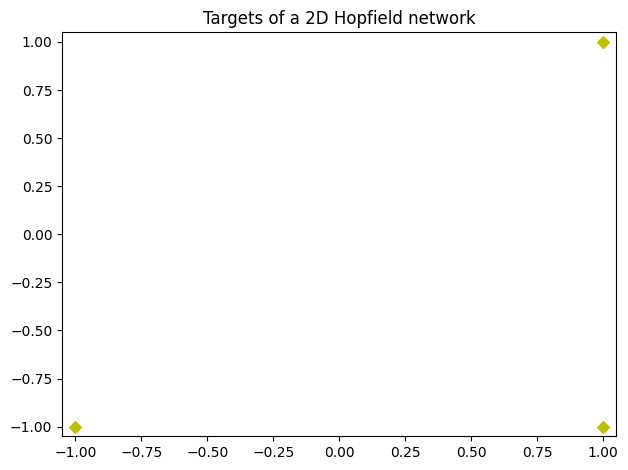

In [ ]:
targets = np.array([[1, 1], [-1, -1], [1, -1]])
net = HopfieldNetwork(targets)
plot_targets(targets)

### **Exercise 1**
Simulate the state evolution for various input vectors (e.g. random points or points of high symmetry) and note down the obtained attractors after a sufficient number of iterations.

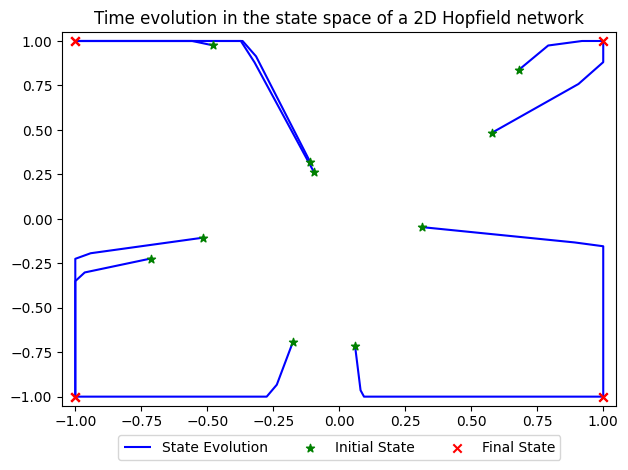

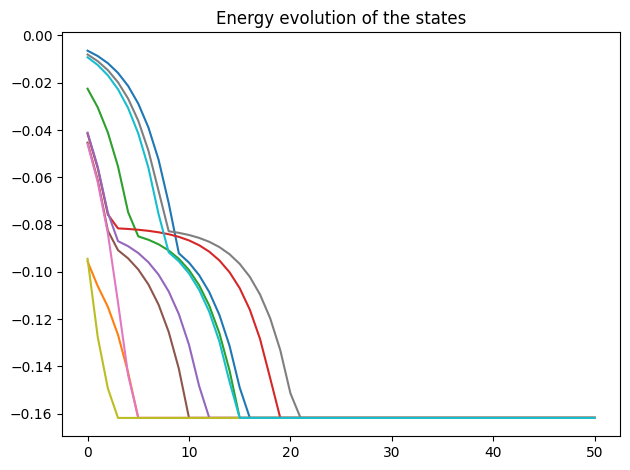

In [ ]:
# Random inputs:
inputs = 2*rng.uniform(size=(10, 2))-1  # rng.uniform returns random numbers between 0 and 1, so rescale it to the interval [-1,1]
states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

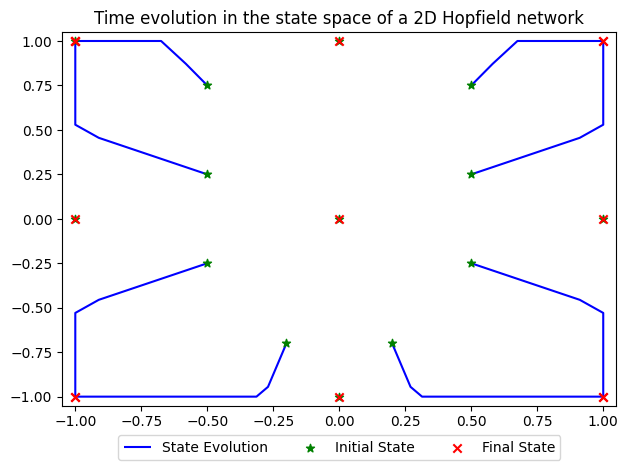

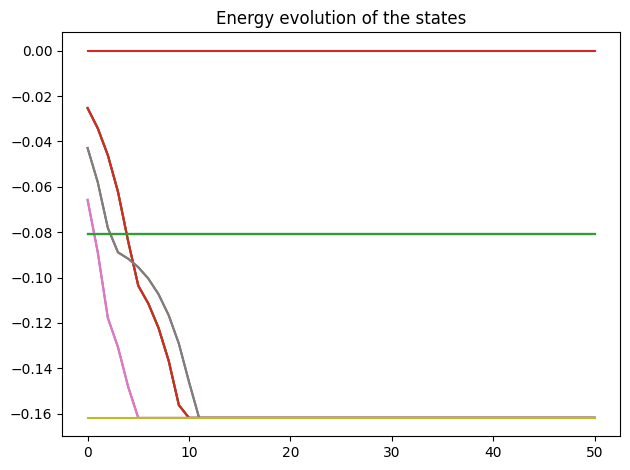

In [ ]:
# Particular inputs of interest, i.e. points of high symmetry:
inputs = np.array([
    [0.5, 0.25], [-0.5, -0.25], [-0.5, 0.25], [0.5, -0.25],
    [0.5, 0.75], [-0.2, -0.7], [-0.5, 0.75], [0.2, -0.7],
    # Spurious stable attractor:
    [-1.0, 1.0],
    # Unstable attractors:
    [1.0, 0.0],
    [-1.0, 0.0],
    [0.0, 1.0],
    [0.0, -1.0],
    [0.0, 0.0],
    ])
states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

#### **Exercise 1.a:**
Are the real attractors the same as those used to create the network? If not, why do we get these unwanted attractors?

Real attractors, i.e. targets:


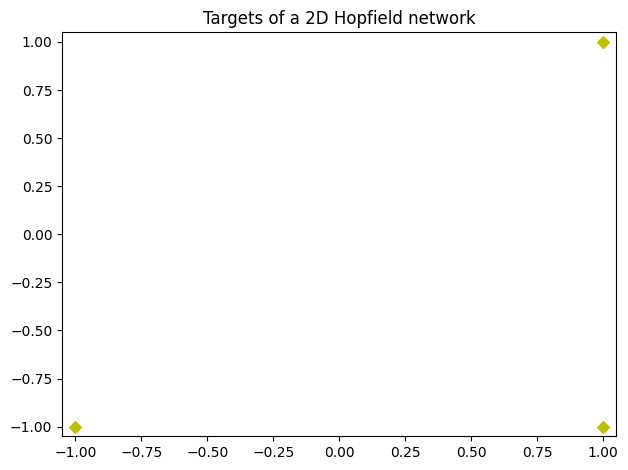

All attractors, incl. spurious:


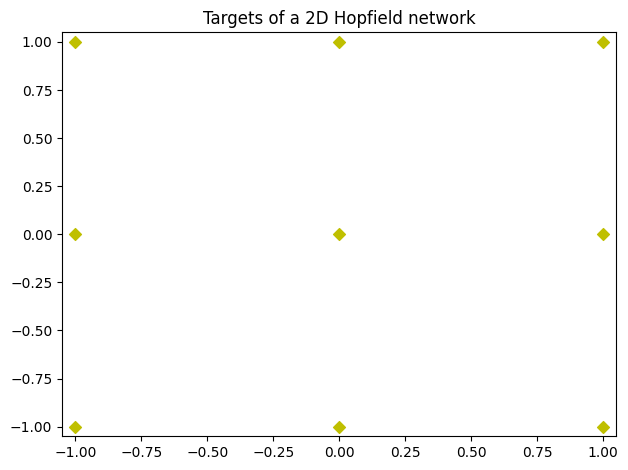

In [ ]:
print("Real attractors, i.e. targets:")
plot_targets(targets)
final_states = np.unique(np.round(states[:, :, -1], 3), axis=0)
print("All attractors, incl. spurious:")
plot_targets(final_states)

In [ ]:
alpha = lambda x: np.clip(x, -1, 1)
assert (alpha(np.array([[-2.0, 1.0, 0.0, 3.0]])) == np.array([[-1.0, 1.0, 0.0, 1.0]])).all()

W = np.array([[3, 1], [1, 3]])
x_0 = np.array([[0.5], [-0.75]])
print(f"{x_0 = }")
x_1 = alpha(W @ x_0)
print(f"{x_1 = }")
x_2 = alpha(W @ x_1)
print(f"{x_2 = }")
x_3 = alpha(W @ x_2)
print(f"{x_3 = }")
print()

W = np.array([[3, 1], [1, 3]])
x_0 = np.array([[-0.5], [0.75]])
print(f"{x_0 = }")
x_1 = alpha(W @ x_0)
print(f"{x_1 = }")
x_2 = alpha(W @ x_1)
print(f"{x_2 = }")
x_3 = alpha(W @ x_2)
print(f"{x_3 = }")
print()

W = np.array([[3, 1], [1, 3]])
x_0 = np.array([[0.0], [0.0]])
print(f"{x_0 = }")
x_1 = alpha(W @ x_0)
print(f"{x_1 = }")
x_2 = alpha(W @ x_1)
print(f"{x_2 = }")
x_3 = alpha(W @ x_2)
print(f"{x_3 = }")
print()

W = np.array([[3, 1], [1, 3]])
x_0 = np.array([[1.0], [0.0]])
print(f"{x_0 = }")
x_1 = alpha(W @ x_0)
print(f"{x_1 = }")
x_2 = alpha(W @ x_1)
print(f"{x_2 = }")
x_3 = alpha(W @ x_2)
print(f"{x_3 = }")
print()

x_0 = array([[ 0.5 ],
       [-0.75]])
x_1 = array([[ 0.75],
       [-1.  ]])
x_2 = array([[ 1.],
       [-1.]])
x_3 = array([[ 1.],
       [-1.]])

x_0 = array([[-0.5 ],
       [ 0.75]])
x_1 = array([[-0.75],
       [ 1.  ]])
x_2 = array([[-1.],
       [ 1.]])
x_3 = array([[-1.],
       [ 1.]])

x_0 = array([[0.],
       [0.]])
x_1 = array([[0.],
       [0.]])
x_2 = array([[0.],
       [0.]])
x_3 = array([[0.],
       [0.]])

x_0 = array([[1.],
       [0.]])
x_1 = array([[1.],
       [1.]])
x_2 = array([[1.],
       [1.]])
x_3 = array([[1.],
       [1.]])



#### **Exercise 1.b:**
How many iterations does it typically take to reach the attractor?

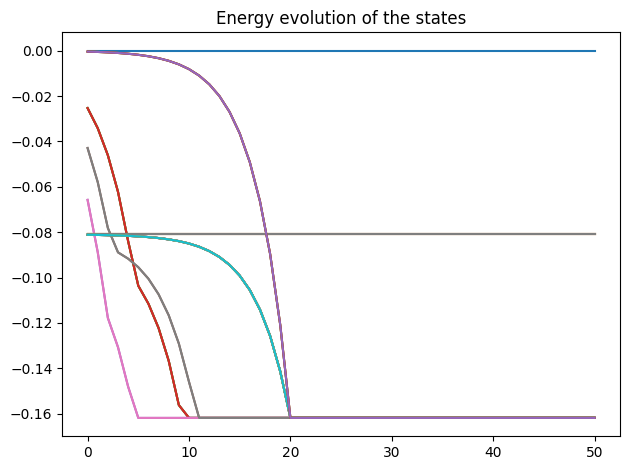

In [ ]:
inputs = np.array([
    [0.5, 0.25], [-0.5, -0.25], [-0.5, 0.25], [0.5, -0.25],
    [0.5, 0.75], [-0.2, -0.7], [-0.5, 0.75], [0.2, -0.7],
    [1.0, 0.0], [1.0, 0.05], [1.0, -0.05],
    [-1.0, 0.0], [-1.0, 0.05], [-1.0, -0.05],
    [0.0, 1.0], [0.05, 1.0], [-0.05, 1.0],
    [0.0, -1.0], [0.05, -1.0], [-0.05, -1.0],
    [0.0, 0.0], [0.05, 0.05], [0.05, -0.05], [-0.05, 0.05], [-0.05, -0.05],
    ])
states, energies = net.simulate(inputs, num_iter=50)
plot_energies(energies)

#### **Exercise 1.c:**
What can you say about the stability of the attractors?

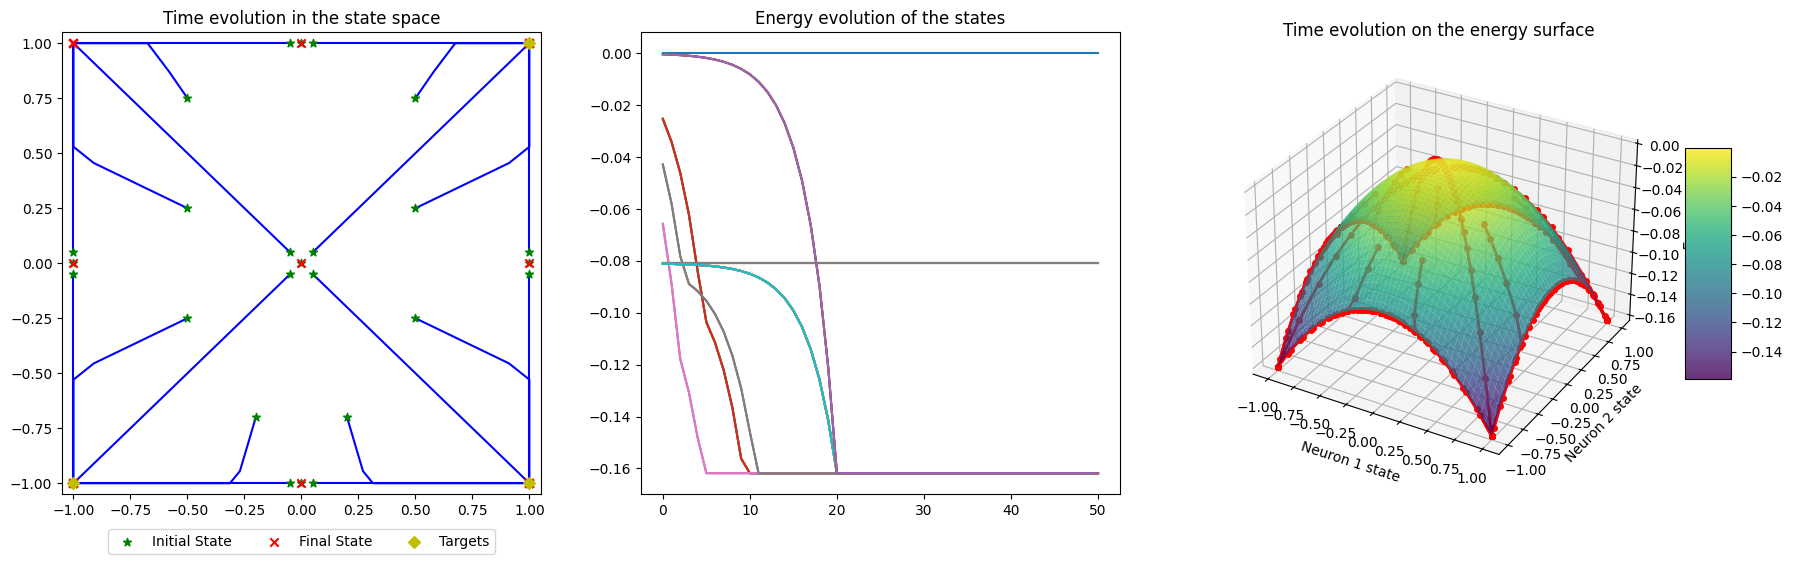

In [ ]:
inputs = np.array([
    [0.5, 0.25], [-0.5, -0.25], [-0.5, 0.25], [0.5, -0.25],
    [0.5, 0.75], [-0.2, -0.7], [-0.5, 0.75], [0.2, -0.7],
    [1.0, 0.0], [1.0, 0.05], [1.0, -0.05],
    [-1.0, 0.0], [-1.0, 0.05], [-1.0, -0.05],
    [0.0, 1.0], [0.05, 1.0], [-0.05, 1.0],
    [0.0, -1.0], [0.05, -1.0], [-0.05, -1.0],
    [0.0, 0.0], [0.05, 0.05], [0.05, -0.05], [-0.05, 0.05], [-0.05, -0.05],
    ])
states, energies = net.simulate(inputs, num_iter=50)
plot_states_energy_surface(net, states, energies, targets=targets)

## 3D Hopfield Network

Create a 3D Hopfield network with target patterns $[1, 1, 1]$, $[-1, -1, 1]$ and $[1, -1, -1]$.

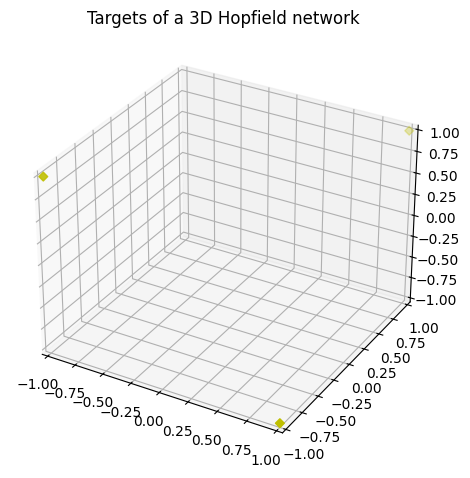

In [ ]:
targets = np.array([[1, 1, 1], [-1, -1, 1], [1, -1, -1]])
net = HopfieldNetwork(targets)
plot_targets(targets)

### **Exercise 2**
Simulate the state evolution for various input vectors (e.g. random points or points of high symmetry) and note down the obtained attractors after a sufficient number of iterations.

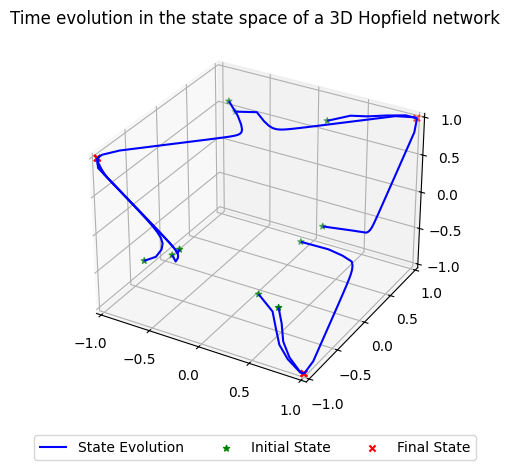

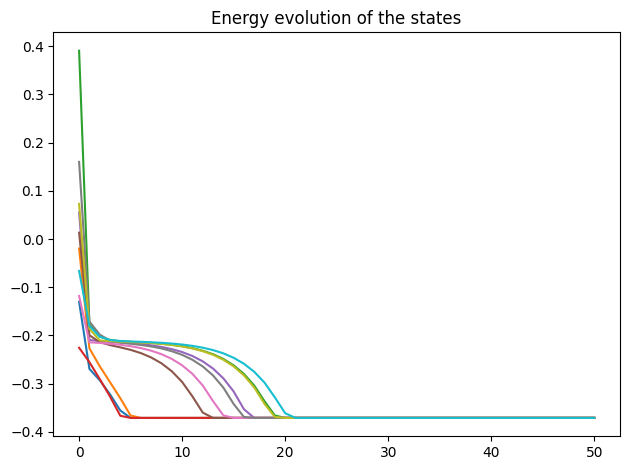

In [ ]:
# Random inputs:
inputs = 2*rng.uniform(size=(10, 3))-1  # rng.uniform returns random numbers between 0 and 1, so rescale it to the interval [-1,1]
states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

#### **Exercise 2.a:**
Are the real attractors the same as those used to create the network? If not, why do we get these unwanted attractors?

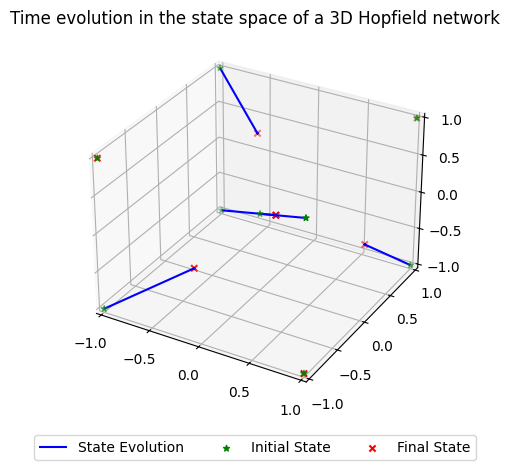

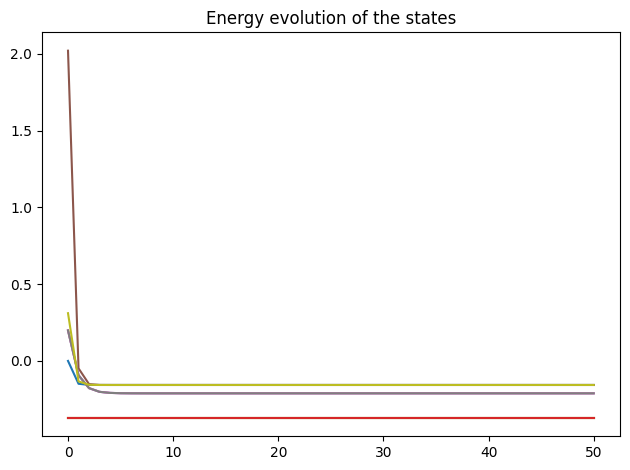

In [ ]:
# Particular inputs of interest, i.e. points of high symmetry:
inputs = np.array([
    # Origin:
    [0, 0, 0],  # not an attractor
    # Targets:
    [1, 1, 1],
    [-1, -1, 1],
    [1, -1, -1],
    # # Other corners:
    [-1, -1, -1],
    [-1, 1, -1],
    [1, 1, -1],
    [-1, 1, 1],
    [1, -1, 1],
    ])
states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

Real attractors, i.e. targets:
[[ 1  1  1]
 [-1 -1  1]
 [ 1 -1 -1]]


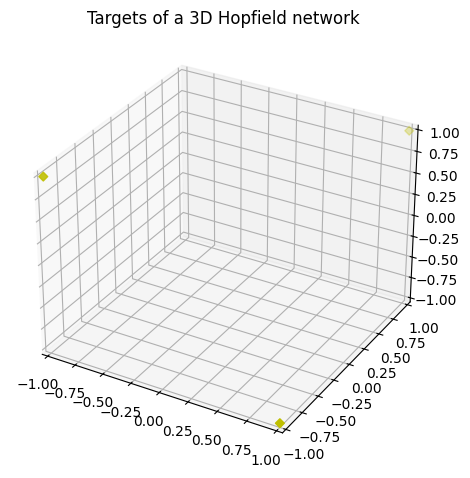

All attractors, incl. spurious:
[[-1.    -1.     1.   ]
 [-0.06  -1.    -0.06 ]
 [-0.06   0.06   1.   ]
 [ 0.367 -0.367  0.367]
 [ 1.    -1.    -1.   ]
 [ 1.     0.06  -0.06 ]
 [ 1.     1.     1.   ]]


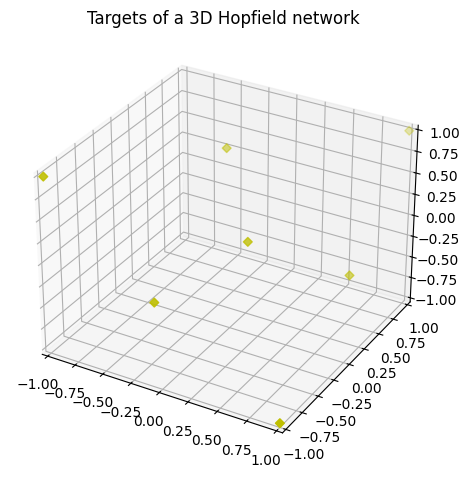

In [ ]:
print("Real attractors, i.e. targets:")
print(targets)
plot_targets(targets)
final_states = np.unique(np.round(states[:, :, -1], 3), axis=0)
print("All attractors, incl. spurious:")
print(final_states)
plot_targets(final_states)

#### **Exercise 2.b:**
How many iterations does it typically take to reach the attractor?

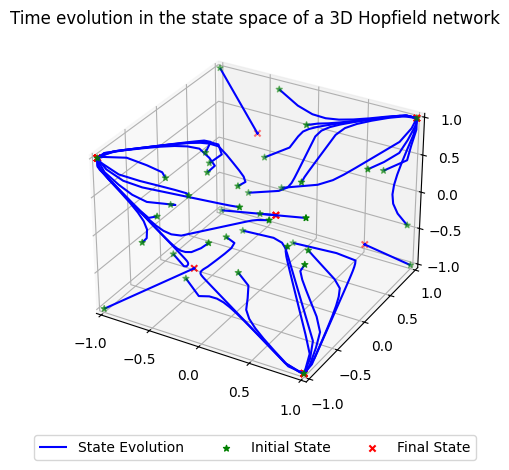

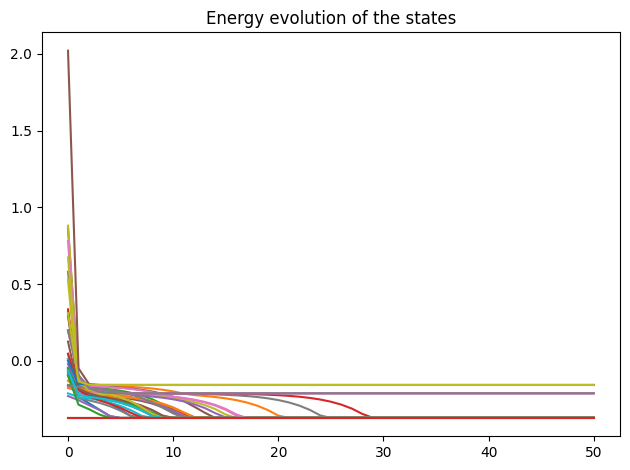

All attractors, incl. spurious:
[[-1.    -1.     1.   ]
 [-0.06  -1.    -0.06 ]
 [-0.06   0.06   1.   ]
 [ 0.367 -0.367  0.367]
 [ 1.    -1.    -1.   ]
 [ 1.     0.06  -0.06 ]
 [ 1.     1.     1.   ]]


In [ ]:
# Random inputs:
inputs_random = 2*rng.uniform(size=(30, 3))-1
# Particular inputs of interest, i.e. points of high symmetry:
inputs_symmetric = np.array([
    # Origin:
    [0, 0, 0],
    # Targets:
    [1, 1, 1],
    [-1, -1, 1],
    [1, -1, -1],
    # Other corners:
    [-1, -1, -1],
    [-1, 1, -1],
    [1, 1, -1],
    [-1, 1, 1],
    [1, -1, 1],
    ])

# Stack the two input arrays
inputs = np.vstack((inputs_random, inputs_symmetric))

states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

final_states = np.unique(np.round(states[:, :, -1], 3), axis=0)
print("All attractors, incl. spurious:")
print(final_states)

#### **Exercise 2.c:**
What can you say about the stability of the attractors?

In [ ]:
perturbation_level = 0.05

perturbed_attractors = (np.array([
 [-0.06,  -1.,    -0.06, ],
 [-0.06,   0.06,   1.,   ],
 [ 0.367, -0.367,  0.367,],
 [ 1.,     0.06,  -0.06, ]]) + rng.normal(scale=perturbation_level, size=(4, 3)))
perturbed_attractors = np.clip(perturbed_attractors, -1, 1)

print(perturbed_attractors)

[[-0.07841507 -0.94831325 -0.11383423]
 [-0.06642547  0.10015253  1.        ]
 [ 0.427032   -0.33933879  0.27643902]
 [ 1.          0.01244765  0.00151732]]


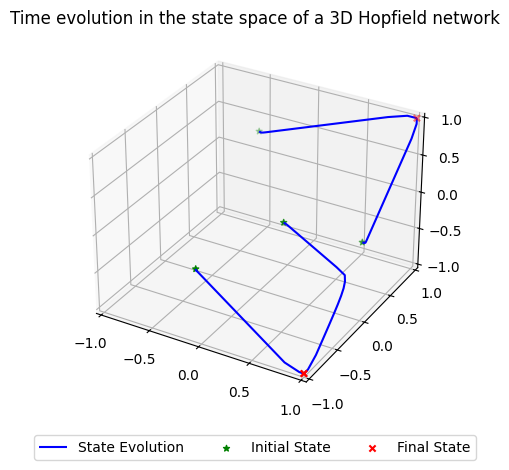

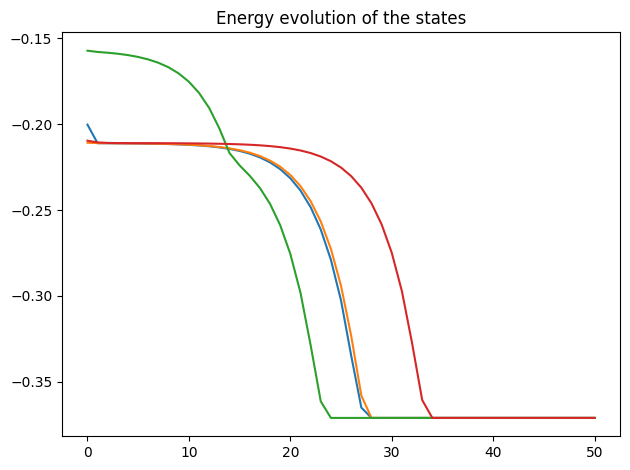

In [ ]:
inputs = perturbed_attractors

states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

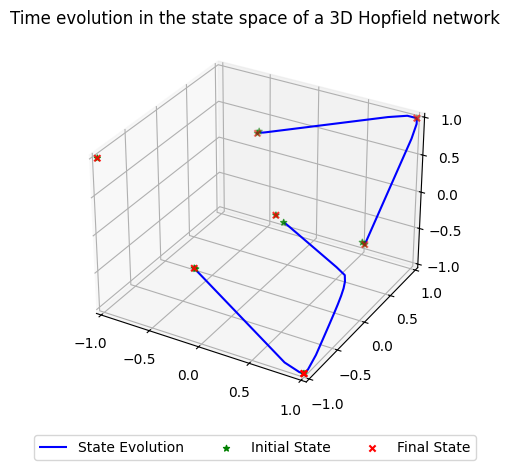

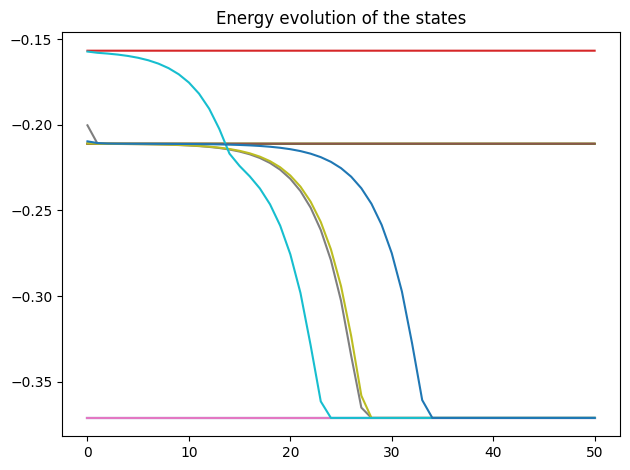

In [ ]:
inputs = np.vstack((final_states, perturbed_attractors))

states, energies = net.simulate(inputs, num_iter=50)
plot_states(states)
plot_energies(energies)

## Digit Reconstruction

We will now train a higher dimensional Hopfield network which has as attractors the handwritten digits from 0 to 9, and test its ability to correctly reconstruct noisy variants of those digits.

We start by loading and preprocessing the MNIST dataset of handwritten digits.

In [5]:
(digits, labels), _ = mnist.load_data()               # Load MNIST digits dataset
digits = {d: digits[labels == d] for d in range(10)}  # Store digits by class label
targets = [digits[d][0] for d in range(10)]           # Select one digit of each class as a target pattern for the Hopfield network
targets, params = HopfieldNetwork.normalize(targets)  # Normalize the targets (rescaling to the interval [-1, 1])

Create the Hopfield network and visualize its target attractors.

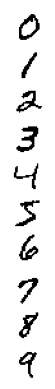

In [6]:
net = HopfieldNetwork(targets)
plot_digits(targets)

### **Exercise 3**
Add some random noise to the digits and check whether the network is able to recover the original digits. Is the Hopfield model always able to reconstruct the noisy digits? If not, why? What is the influence of the noise on the number of iterations?

Try to answer the above questions by playing with these two parameters.

In [16]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 1 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 1 # @param {type:"slider", min:1, max:100, step:1}

In [17]:
digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

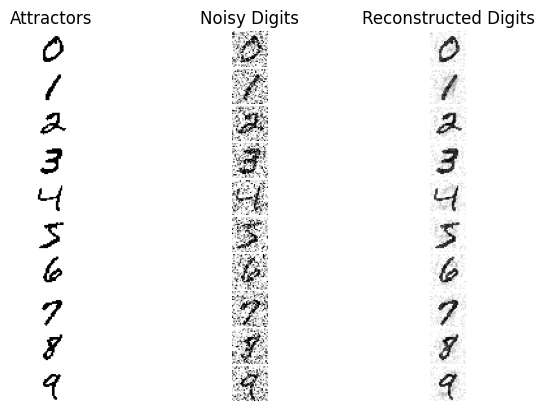

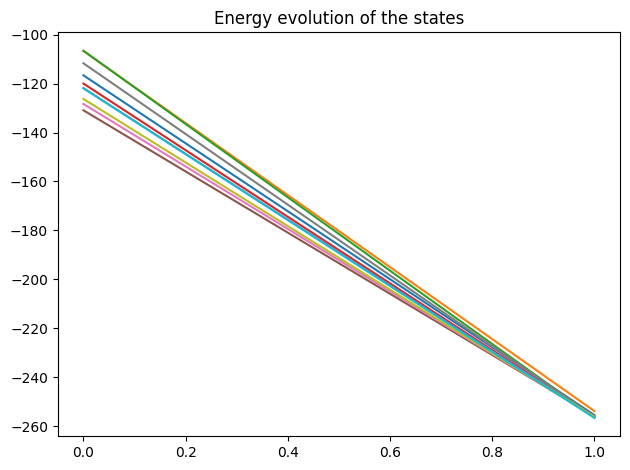

In [18]:
plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

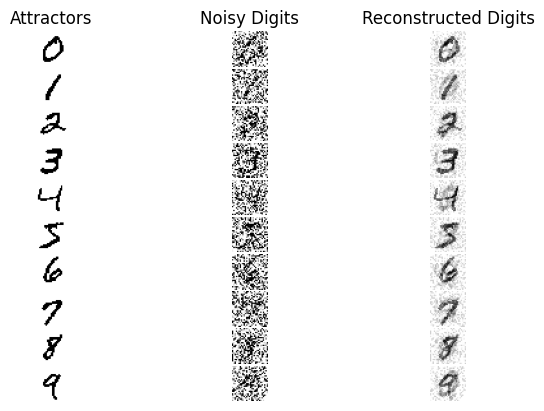

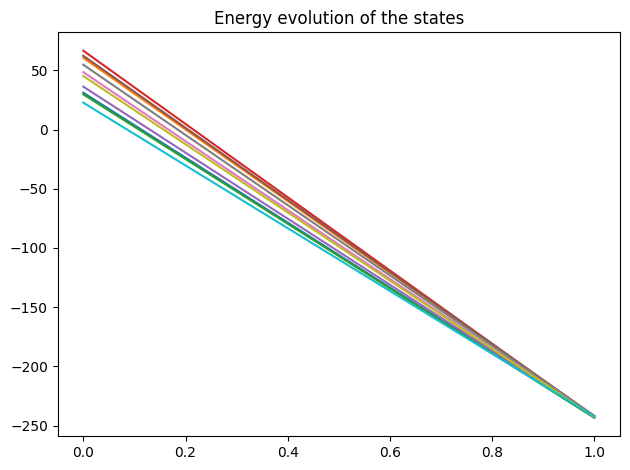

In [22]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 2 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 1 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

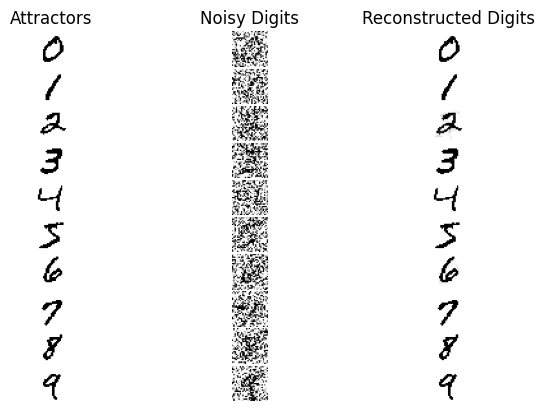

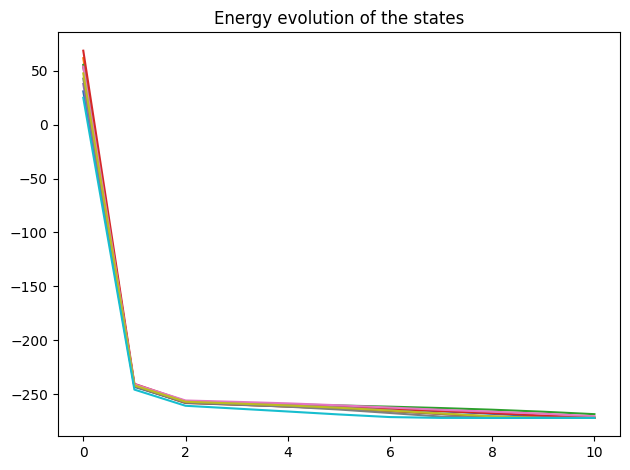

In [20]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 2 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 10 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

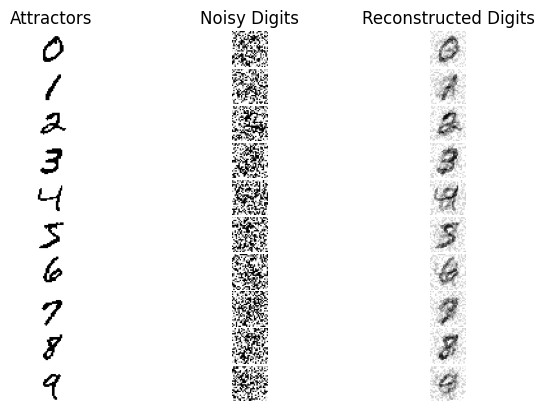

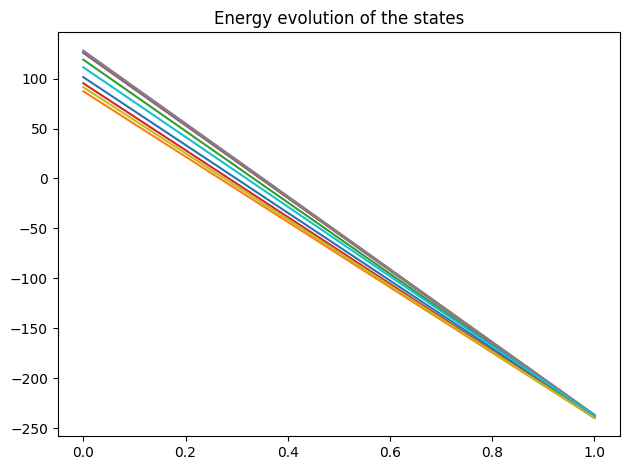

In [23]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 3 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 1 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

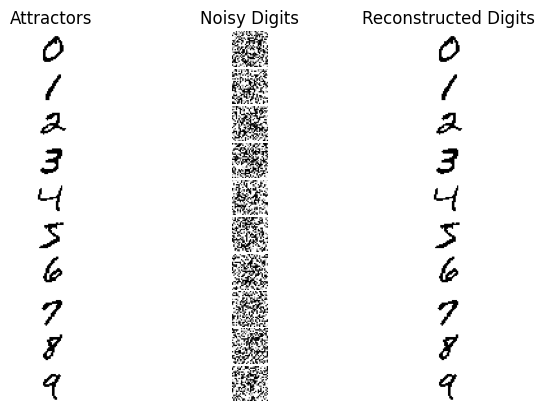

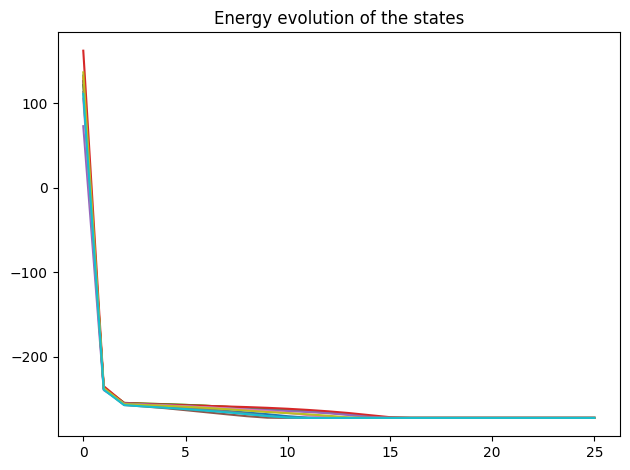

In [27]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 3 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 25 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

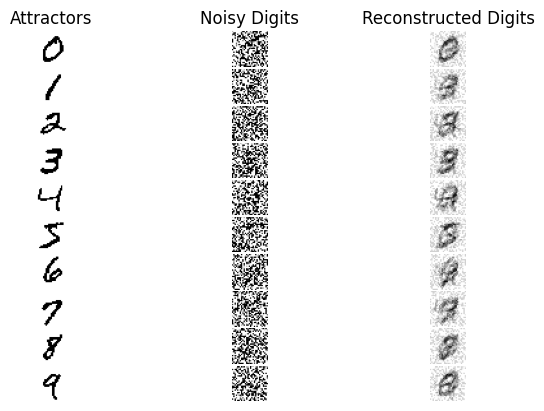

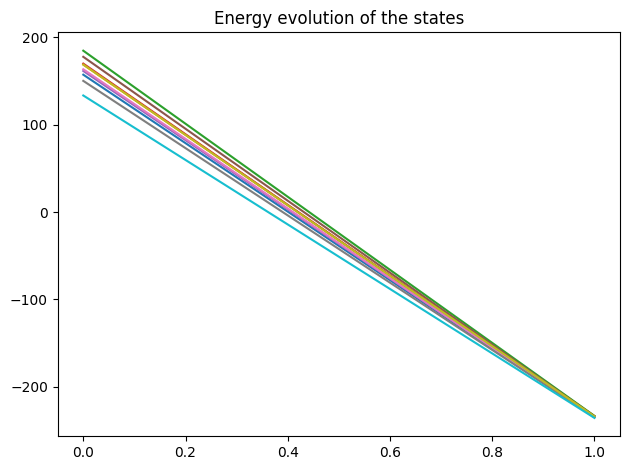

In [33]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 4 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 1 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

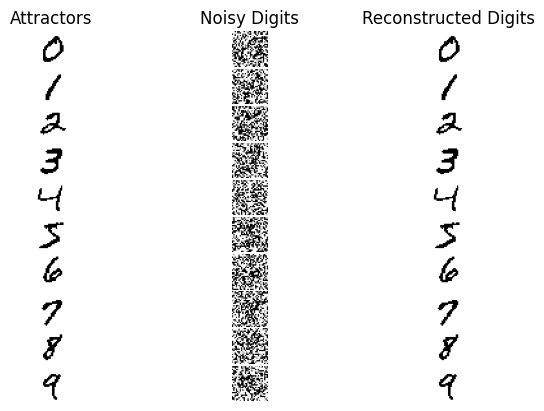

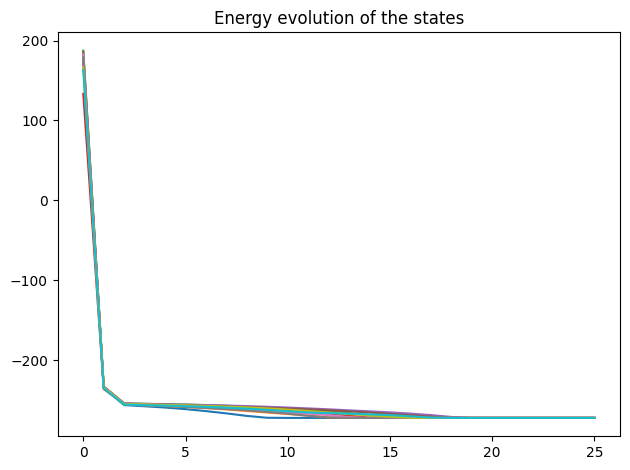

In [30]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 4 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 25 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

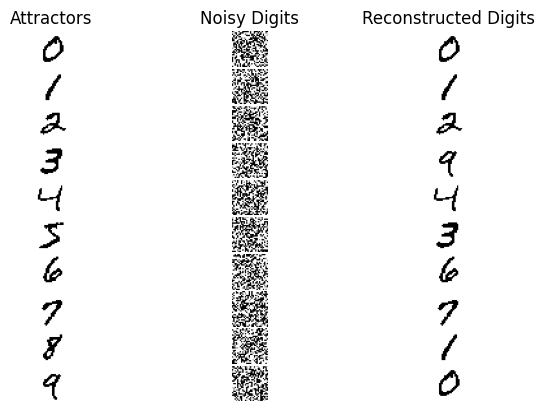

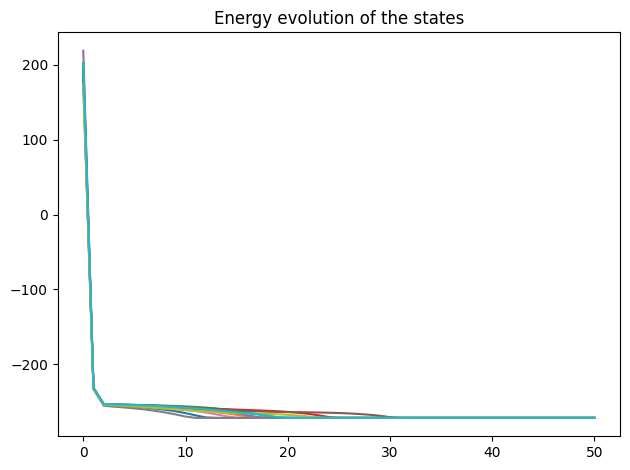

In [32]:
# @title { run: "auto" }

# Standard deviation of the added Gaussian noise
noise_level = 5 # @param {type:"slider", min:0, max:10, step:0.1}
# Number of iterations
num_iter = 50 # @param {type:"slider", min:1, max:100, step:1}

digits_noisy = np.clip(targets + rng.normal(scale=noise_level, size=targets.shape), -1, 1)
states, energies = net.simulate(digits_noisy, num_iter)

plot_digits([targets, digits_noisy, states[:,:,-1]], ["Attractors", "Noisy Digits", "Reconstructed Digits"], "digits")
plot_energies(energies, "digits_energy")

## Extra
Some additional things you can experiment with (not necessary for the report):


*   The default learning algorithm to setup the Hopfield networks is more complex than the Hebbian rule from the lecture slides. By passing `"Hebb"` as the second parameter when creating the networks, you can see the difference between both learning algorithms.
*   The default simulation algorithm used by the Hopfield networks updates the neurons in synchronous mode. By passing `sync=False` as the third parameter to the `simulate` method, you can experiment with asynchronous updates of the neurons.
*   Instead of adding noise, you can try to pass some alternative digits (not used as training patterns) as initial states to the network; or try to occlude specific parts of the input images.
*   You can experiment with other keras datasets, have a look at the different [available datasets](https://keras.io/api/datasets/).

